Name: Akshay Sanghai

Email: sanghai.akshay@gmail.com

###Project Description:

Image caption generator based on Vinyals model (https://github.com/anuragmishracse/caption_generator)

In this tutorial, we will learn to build a image caption generator based on Vinyals model (https://arxiv.org/pdf/1411.4555.pdf). 

This is how the model looks like. We encode the image using a CNN (densenet in this case) and use RNN (LSTM in this case) to generate words. We will go into the details of how we encode images and then train the model using LSTMs.

![](https://shadowthink.com/images/cv/nic.png)

We will use Flickr8k dataset to train our machine learning model. Although many other image captioning datasets (Flickr30k, COCO) are available, Flickr8k is chosen because it takes only a few hours of training on GPU to produce a good model. The dataset contains 8000 of images each of which has 5 captions by different people. Having more than one caption for each image is desirable because an image can be described in many ways.

This is how the flow of tutorial looks:
1. Download Flickr dataset
2. Preprocess the dataset
  - preprocess images 
  - preprocess captions
3. Get training data
4. Create tokenizer to process captions
5. Define batch generator
6. Define the caption generator model
7. Find the optimum learning rate
8. Calculate BLEU-1 score
9. Different things I tried
10. What else we can try?
11. References and further reading

We will go through each of the steps in detail covering why they were done and how they were done. Don't worry about the terms used above, we will cover all of them and I will also include links for further reading.



In [0]:
!kill -9 -1

Let's start with importing all the modules that we will use.

In [1]:
!pip install keras
import pickle
from keras.preprocessing import image
import numpy as np 
from keras.applications.imagenet_utils import preprocess_input	
import matplotlib.pyplot as plt
from keras.models import Model
from keras.applications.densenet import DenseNet121
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import image, sequence
from keras.layers import Embedding, Input
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.layers import (BatchNormalization, Concatenate, Dense, LSTM,TimeDistributed)
from keras.models import Model
from keras.optimizers import Adam
import math
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint
import keras.backend as K
import tensorflow as tf
import nltk

Using TensorFlow backend.


In [2]:
!ls -lrt 
#model.summary()
#!rm -rf __MACOSX Flicker8k_Dataset   Flickr8k_Dataset.zip Flickr8k_text.zip Flickr8k_text 
#!ls -lrt

total 4
drwxr-xr-x 2 root root 4096 Aug 15 00:55 sample_data
lrwxrwxrwx 1 root root    8 Aug 15 00:55 datalab -> /content


In [0]:
model.load_weights('weights-improvement-03-1.83.hdf5')

### 1. Download Flickr dataset
The dataset is available after filling out this [form](https://forms.illinois.edu/sec/1713398). Basically, we will be getting the links mentioned below. After downloading the dataset, we unzip the data. 

Let's review what is there in the files:
- Flicker8k_Dataset: This folder has all the images.
- Flickr8k_text: This folder has several files
 - Flickr_8k.trainImages.txt : This file has list of image names separated by line to be used for training.
 - Flickr_8k.testImages.txt : This file has list of image names separated by line to be used for testing.
 - Flickr8k.token.txt : This file has image caption pair separated by line in the format mentioned below.
   - "1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way ."

In [3]:
!wget  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
!wget  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip
!unzip -q Flickr8k_Dataset.zip
!mkdir Flickr8k_text && unzip -q Flickr8k_text.zip -d Flickr8k_text
!ls

--2018-08-16 17:50:53--  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
Resolving nlp.cs.illinois.edu (nlp.cs.illinois.edu)... 192.17.58.132
Connecting to nlp.cs.illinois.edu (nlp.cs.illinois.edu)|192.17.58.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115419746 (1.0G) [application/zip]
Saving to: ‘Flickr8k_Dataset.zip’

Flickr8k_Dataset.zi 100%[===================>]   1.04G  25.9MB/s    in 43s     

2018-08-16 17:51:36 (24.9 MB/s) - ‘Flickr8k_Dataset.zip’ saved [1115419746/1115419746]

--2018-08-16 17:51:38--  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip
Resolving nlp.cs.illinois.edu (nlp.cs.illinois.edu)... 192.17.58.132
Connecting to nlp.cs.illinois.edu (nlp.cs.illinois.edu)|192.17.58.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2340801 (2.2M) [application/zip]
Saving to: ‘Flickr8k_text.zip’

Flickr8k_text.zip   100%[=================

### 2. Preprocess the dataset
There are few things that we need to do here. 
- First is we need to get image features for each image. If you remember, we mentioned we will be using Densenet as image encoder. Processing the image through CNN takes some time, so we preprocess and collect the 1024-sized vector for each image. Consider this as a representation of image in a smaller dimension. Each image is loaded as 224x224x3 matrix and then converted to 1024-sized vector using the Densenet Model.

- Second, we need to process the captions and add a "EOS" end of sentence character. We use "zeosz" for EOS. We don't use any start character. We feed the image encoding at t=0 and feed the first word at t=1. We need some more processing for captions which is done in step 4.

- Third, we need to create files for training and test dataset. The lines of these files are in this format.
  - "3107889179_106d223345.jpg	A grandmother and a small child are sitting at a table being served by a woman in a black shirt . zeosz"
  - Flickr8k_text/flickr_8k_train_dataset.txt for training
  - Flickr8k_text/flickr_8k_test_dataset.txt for testing
  
We have done this in 3 steps. Lets go through the code.

This section of code from https://github.com/anuragmishracse/caption_generator/blob/master/caption_generator/prepare_dataset.py

*load_image function* takes the image path and returns 224x224x3 matrix for the image. We will use this function when we get the encoding of the image.

In [0]:
def load_image(path):
    img = image.load_img(path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return np.asarray(x)

*load_encoding_model*: This function is used to load the DenseNet121 model with pretrained weights and return a model which takes image input and outputs the last layer of DenseNet model. 

*get_encoding_model*: This function takes the image encoding model and img matrix and returns a 1024 vector representation of the image. We have done one reshaping, which changes dimension from (1,1024) to (1024,).

In [0]:
counter = 0

def load_encoding_model():
  image_model = DenseNet121(weights='imagenet', include_top=False, pooling='avg')
  for layer in image_model.layers:
    layer.trainable = False
  transfer_layer = image_model.layers[-1]
  image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)
  return image_model_transfer

def get_encoding(model, img):
  global counter
  counter += 1
  image = load_image('Flicker8k_Dataset/'+str(img))
  pred = model.predict(image)
  print( pred.shape)
  pred = np.reshape(pred, pred.shape[1])
  print("Encoding image: "+str(counter))
  print( pred.shape)
  return pred

*L1-L6*: Here we open the trainImages and textImages file and save the list of train images in train_imgs and the list of test images in test_imgs.

*L10-L11*: Here we define the files for training and test dataset. 

*L15-L23*: Here we define a dictionary "data". The key of this dictionary is an image name and value is the list of captions. For each image, we have 5 captions. This data is present in "Flickr8k.token.txt", we are extracting it to separate train and test dataset and also add EOS character ("zeosz") at the end of each caption.

*L30-L36*: encoded_images is a dictionary for which key is image name and value is the encoding of the image (1024-sized vector). For each of the image in train_imgs list, we find the encoding. Then we write a line in the training dataset file, which has image name and caption separated by tab.

*L40-L46*: Same as above for test data.

*L48-L49*: Finally we dump the encoded_images dictionary in a pickle file. We can use this file to get the image encoding.

In [6]:
no_imgs = -1
with open('Flickr8k_text/Flickr_8k.trainImages.txt','r') as f_train_images:
	train_imgs = f_train_images.read().strip().split('\n') if no_imgs == -1 else f_train_images.read().strip().split('\n')[:no_imgs]
	
with open('Flickr8k_text/Flickr_8k.testImages.txt','r') as f_test_images:
	test_imgs = f_test_images.read().strip().split('\n') if no_imgs == -1 else f_test_images.read().strip().split('\n')[:no_imgs]
  
with open('Flickr8k_text/Flickr_8k.devImages.txt','r') as f_valid_images:
	valid_imgs = f_valid_images.read().strip().split('\n') if no_imgs == -1 else f_valid_images.read().strip().split('\n')[:no_imgs]

print("number of training images "+ str(len(train_imgs)))
print("number of test images "+ str(len(test_imgs)))
print("number of valid images "+ str(len(valid_imgs)))


f_train_dataset = open('Flickr8k_text/flickr_8k_train_dataset.txt','w')
f_test_dataset = open('Flickr8k_text/flickr_8k_test_dataset.txt','w')
f_valid_dataset = open('Flickr8k_text/flickr_8k_valid_dataset.txt','w')

f_captions = open('Flickr8k_text/Flickr8k.token.txt', 'r')
captions = f_captions.read().strip().split('\n')
data = {}
for row in captions:
  #print(row)
  row = row.split("\t")
  row[0] = row[0][:len(row[0])-2]  #get image name
  try:
    data[row[0]].append(row[1])    #image name with multiple captions
  except:
    data[row[0]] = [row[1]]
f_captions.close()

encoded_images = {}
encoding_model = load_encoding_model()

c_train = 0
for img in train_imgs:
	encoded_images[img] = get_encoding(encoding_model, img)
	for capt in data[img]:
		caption = capt+" zeosz"
		f_train_dataset.write(img+"\t"+caption+"\n")
		f_train_dataset.flush()
		c_train += 1
f_train_dataset.close()

c_test = 0
for img in test_imgs:
	encoded_images[img] = get_encoding(encoding_model, img)
	for capt in data[img]:
		caption = capt+" zeosz"
		f_test_dataset.write(img+"\t"+caption+"\n")
		f_test_dataset.flush()
		c_test += 1
f_test_dataset.close()

c_valid = 0
for img in valid_imgs:
	encoded_images[img] = get_encoding(encoding_model, img)
	for capt in data[img]:
		caption = capt+" zeosz"
		f_valid_dataset.write(img+"\t"+caption+"\n")
		f_valid_dataset.flush()
		c_valid += 1
f_valid_dataset.close()

with open( "encoded_images.p", "wb" ) as pickle_f:
	pickle.dump( encoded_images, pickle_f )  


number of training images 6000
number of test images 1000
number of valid images 1000
30015488/30011760 [==============================] - 5s 0us/step
(1, 1024)
Encoding image: 1
(1024,)
(1, 1024)
Encoding image: 2
(1024,)
(1, 1024)
Encoding image: 3
(1024,)
(1, 1024)
Encoding image: 4
(1024,)
(1, 1024)
Encoding image: 5
(1024,)
(1, 1024)
Encoding image: 6
(1024,)
(1, 1024)
Encoding image: 7
(1024,)
(1, 1024)
Encoding image: 8
(1024,)
(1, 1024)
Encoding image: 9
(1024,)
(1, 1024)
Encoding image: 10
(1024,)
(1, 1024)
Encoding image: 11
(1024,)
(1, 1024)
Encoding image: 12
(1024,)
(1, 1024)
Encoding image: 13
(1024,)
(1, 1024)
Encoding image: 14
(1024,)
(1, 1024)
Encoding image: 15
(1024,)
(1, 1024)
Encoding image: 16
(1024,)
(1, 1024)
Encoding image: 17
(1024,)
(1, 1024)
Encoding image: 18
(1024,)
(1, 1024)
Encoding image: 19
(1024,)
(1, 1024)
Encoding image: 20
(1024,)
(1, 1024)
Encoding image: 21
(1024,)
(1, 1024)
Encoding image: 22
(1024,)
(1, 1024)
Encoding image: 23
(1024,)
(1, 102

In [7]:
!tail -10 Flickr8k_text/flickr_8k_train_dataset.txt
!tail -10 Flickr8k_text/flickr_8k_test_dataset.txt
!tail -10 Flickr8k_text/flickr_8k_valid_dataset.txt
print(len(train_imgs))
print(len(test_imgs))
print(len(valid_imgs))

3107889179_106d223345.jpg	A grandmother and a small child are sitting at a table being served by a woman in a black shirt . zeosz
3107889179_106d223345.jpg	an old lady and a child are sitting at an ornate green table whilst being served by food by an African person . zeosz
3107889179_106d223345.jpg	A young boy , a young girl , an older woman and a man gather for a meal zeosz
3107889179_106d223345.jpg	People are sitting at a green table set with placemats and green glasses . zeosz
3107889179_106d223345.jpg	Various members of a family are gathering around a decorated dining table . zeosz
2671602981_4edde92658.jpg	A little girl in a bathing suit leaps up in the water . zeosz
2671602981_4edde92658.jpg	A little girl wearing a black tankini is jumping in the air with water in the background . zeosz
2671602981_4edde92658.jpg	A young girl in a swimming suit jumps into a body of water . zeosz
2671602981_4edde92658.jpg	A young girl jumping out of the water zeosz
2671602981_4edde92658.jpg	The gir

### 3. Get training data
*get_data*: This function takes the file path and returns a tuple of images and captions. File path can be training or test data. 

*L12-L17*: We get the list of train_images and train_captions. num_train_images shows the number of data points. This is actually total number of training images multiplied by 5 (for each image, we have 5 captions). 

In [8]:
def get_data(file_path):
  f_dataset = open(file_path,'r')
  images = []
  captions = []
  f_dataset = f_dataset.read().strip().split('\n')
  for line in f_dataset:
    row = line.split('\t')
    images.append(row[0])
    captions.append(row[1])
  return(images,captions)

train_images, train_captions = get_data('Flickr8k_text/flickr_8k_train_dataset.txt')
valid_images, valid_captions = get_data('Flickr8k_text/flickr_8k_valid_dataset.txt')
num_train_images = len(train_images)
print(num_train_images)
num_valid_images = len(valid_images)
print(train_captions[:10])
print(valid_captions[:10])
max_caption = max(train_captions, key=len)
max_caption_length = len(max_caption.split(" "))
print(max_caption_length)
max_caption_valid = max(valid_captions, key=len)
max_caption_valid_length = len(max_caption_valid.split(" "))
print(max_caption_valid_length)

30000
['A black dog is running after a white dog in the snow . zeosz', 'Black dog chasing brown dog through snow zeosz', 'Two dogs chase each other across the snowy ground . zeosz', 'Two dogs play together in the snow . zeosz', 'Two dogs running through a low lying body of water . zeosz', 'A little baby plays croquet . zeosz', 'A little girl plays croquet next to a truck . zeosz', 'The child is playing croquette by the truck . zeosz', 'The kid is in front of a car with a put and a ball . zeosz', 'The little boy is playing with a croquet hammer and ball beside the car . zeosz']
['the boy laying face down on a skateboard is being pushed along the ground by another boy . zeosz', 'Two girls play on a skateboard in a courtyard . zeosz', 'Two people play on a long skateboard . zeosz', 'Two small children in red shirts playing on a skateboard . zeosz', 'two young children on a skateboard going across a sidewalk zeosz', 'a boy in a blue top is jumping off some rocks in the woods . zeosz', 'A b

### 4. Create tokenizer to process captions
Why do we need a tokenizer? We can't feed words directly in a LSTM. We have to feed the words represented by numbers. Tokenizer is available from keras preprocessing and we will use it for this task. One thing I would like to point out is when tokenizer fits on the texts, it removes punctuation and then creates the mapping from word to numbers. We have defined vocab_size (we will use later) as number of words in tokenizer plus 1 to accomodate for 0. The safe option is to use a vocab_size little bigger than number of words in training data to accomodate for unseen words.

*L3*: train_encoded_captions is the tokenized version of train_captions. All the words of captions have been converted to numbers. We will use this list later in batch_generator.

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_captions)
train_encoded_captions = tokenizer.texts_to_sequences(train_captions)
valid_encoded_captions = tokenizer.texts_to_sequences(valid_captions)
print(train_encoded_captions[:10])

max_caption = max(train_encoded_captions, key=len)
print(max_caption)
print(len(max_caption))
print(tokenizer.word_index)
print(max_caption[:3])
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)
end_token = tokenizer.word_index['zeosz']
print(len(train_encoded_captions))

[[1, 14, 8, 6, 31, 256, 1, 13, 8, 3, 4, 41, 2], [14, 8, 257, 24, 8, 32, 41, 2], [12, 30, 818, 137, 83, 126, 4, 138, 165, 2], [12, 30, 81, 141, 3, 4, 41, 2], [12, 30, 31, 32, 1, 535, 448, 258, 11, 23, 2], [1, 39, 134, 111, 2276, 2], [1, 39, 18, 111, 2276, 90, 19, 1, 467, 2], [4, 42, 6, 34, 4449, 56, 4, 467, 2], [4, 265, 6, 3, 49, 11, 1, 136, 9, 1, 1155, 7, 1, 37, 2], [4, 39, 15, 6, 34, 9, 1, 2276, 2537, 7, 37, 226, 4, 136, 2]]
[27, 674, 426, 10, 20, 1, 53, 520, 7, 29, 438, 6, 50, 52, 1007, 2166, 3067, 3, 49, 11, 28, 117, 35, 38, 5, 1, 421, 159, 3, 49, 11, 1, 55, 11, 61, 34, 934, 2]
38
{'a': 1, 'zeosz': 2, 'in': 3, 'the': 4, 'on': 5, 'is': 6, 'and': 7, 'dog': 8, 'with': 9, 'man': 10, 'of': 11, 'two': 12, 'white': 13, 'black': 14, 'boy': 15, 'are': 16, 'woman': 17, 'girl': 18, 'to': 19, 'wearing': 20, 'at': 21, 'people': 22, 'water': 23, 'brown': 24, 'red': 25, 'young': 26, 'an': 27, 'his': 28, 'blue': 29, 'dogs': 30, 'running': 31, 'through': 32, 'shirt': 33, 'playing': 34, 'while': 35, 

In [25]:
print(len(train_images))
print(len(train_encoded_captions))

30000
30000


### 5. Define batch generator
For training, we need to define a generator which returns the training input and output in batches. Let's go through the code.

*L3*: Get a list of length batch_size which has randomly generated numbers from 1 to 30000(num_train_images). We do this to have randomness in between the epochs. 

*L7-L8*: transfer_values array has encoding of images. Its shape will be (batch_size,1024)

*L11-L12*: tokens array has list of encoded captions for the indexes defined in idx.

*L14-L21*: Since captions will be of variable length, we need to pad them with zeros since we are sending data in batch. 

Consider a caption: "Kids are playing the ground zeosz". So, we will feed "Kids are playing the ground" as input to our model and we want our model to predict "Kids are playing the ground zeosz". We feed image at t=0 and LSTM predicts the first word, then we feed the 1st word "kids" at t=1 and then out model predicts "are". This goes on. Finally we we feed "ground" at t=5 and our model predicts "zeosz". This is what we have done in line 23-24. 

What we need to generate per batch is defined by the model defined below. So if you are confused as why we are yielding image encoding and captions input as a list and training output as another list, then have patience. See how the model is defined below.

In [0]:
def train_batch_generator(batch_size):
    i = 0
    while True:
        idx = np.random.randint(num_train_images,
                                size=batch_size)
        idx = [x for x in range(i,i+batch_size)]
        #transfer_values = transfer_values_train[idx]
        transfer_values = [encoded_images[train_images[id]] for id in idx]
        transfer_values = np.asarray(transfer_values)

        #tokens = get_random_caption_tokens(idx)
        tokens = [train_encoded_captions[id] for id in idx]
        tokens = np.asarray(tokens)

        num_tokens = [len(t) for t in tokens]
        
        max_tokens = np.max(num_tokens)
        
        tokens_padded = sequence.pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, :]
        i = i+batch_size
        yield ([[transfer_values, decoder_input_data], decoder_output_data])

In [0]:
def valid_batch_generator(batch_size):
    i=0
    while True:
        #idx = np.random.randint(num_valid_images,
        #                        size=batch_size)
        idx = [x for x in range(i,i+batch_size)]
        #transfer_values = transfer_values_train[idx]
        transfer_values = [encoded_images[valid_images[id]] for id in idx]
        transfer_values = np.asarray(transfer_values)

        #tokens = get_random_caption_tokens(idx)
        tokens = [valid_encoded_captions[id] for id in idx]
        tokens = np.asarray(tokens)

        num_tokens = [len(t) for t in tokens]
        
        max_tokens = np.max(num_tokens)
        
        tokens_padded = sequence.pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, :]
        i = i+batch_size
        yield ([[transfer_values, decoder_input_data], decoder_output_data])

### 6. Define the caption generator model
The model is based on the paper presented by Vinyals et al. We use densenet as image encoder and use LSTM for caption generation. We will go into the specifics below. 

**Loss function**: The output of the model is a sequence of one-hot encoded arrays. In order to train the model we need to supply the one-hot encoded arrays that we desire to see on the model's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

However, our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has "vocab_size"(7377) elements so it would be extremely wasteful to convert the entire data-set to one-hot encoded arrays. We could do this conversion from integers to one-hot arrays in the batch_generator() above.

A better way is to use a so-called sparse cross-entropy loss-function, which does the conversion internally from integers to one-hot encoded arrays. 

I have taken this loss function code from "https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb". Please refer to this link for additional details.

shape of y_true: (batch_size,max_tokens) (Note: max_tokens changes for each batch)
shape of y_pred: (batch_size,max_tokens,vocab_size)

For every t=t, y_pred predicts the probability of each word in the vocab. For same time step, y_true has a number. For ex, y_true at t=2 is 100. We want y_pred to give max probability to 100. This is how our loss function works in simple terms (I have ignored dimensions here).

In [0]:
def sparse_cross_entropy(y_true, y_pred):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

**Caption Generator Model**: 

This is what we have been waiting for. The only thing that I will not cover is how I arrived at the "embedding_size" which is same as "lstm_output_size". I will cover this in the section "Different things I tried". 

Why we do image embedding and word embedding?
- Our image encoding will be of shape (batch_size,1024) and word_encoding will be of shape (batch_size,max_tokens-1). We need to concatenate them together to feed to LSTM. Since image encoding and word encoding are of different shape, we need to use dense layer of keras to convert them to size 300.

Now let's go through the code line by line.

*L3-L7*: Here we define how we will provide the image encoding and how we do the embedding. image_input will be encoding of images (shape:batch_size,1024) and output will be of shape (batch_size,1,300).

*L9-L10*: Keras provides Embedding layer to convert list of words into a vector of specific size. Internally, its using a dense fully-connected layer. We need to convert each word, represented by a number, into a vector of size 300. For ex Consider the max_token for a batch is 20. Shape of sentence_input is (batch_size,20). Then this layer will convert this to (batch_size,20,300)

*L15*: We then merge image embedding and word embedding. Carrying forward the same example mentioned above, the shape of output of this layer would be (batch_size,21,300).

*L17*: We chose this learning rate based on the graph plotted in section7. In simple terms, we chose a learning rate for which the loss decreases fastly and the model also converges.

*L20-L24*: We define the LSTM section here. We have set "return_sequences" to True as we need output for each time step.

*L26*: Finally we need to convert this vector of 300  to 7377 (vocab_size). Time Distributed applies the dense layer to each of the time step and prevents interaction among the time steps.

*L28*: Finally we define the model for this input is image_input and sentence_input as list and output is the sequence_output as we defined above.

In [0]:
embedding_size = 300

image_model = Sequential()
image_model.add(Dense(embedding_size, input_dim = 1024))
image_model.add(RepeatVector(1))
image_embedding = image_model.output
image_input = image_model.input

sentence_input = Input(shape=[None])
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=embedding_size
                           )(sentence_input)


sequence_input = Concatenate(axis=1)([image_embedding, word_embedding])

learning_rate = 0.00005
lstm_output_size = 300

input_ = sequence_input

input_ = BatchNormalization(axis=-1)(input_)
lstm_out = LSTM(units=lstm_output_size,
                  return_sequences=True)(input_)

sequence_output = TimeDistributed(Dense(units=vocab_size))(lstm_out)

model = Model(inputs=[image_input, sentence_input],
              outputs=sequence_output)






In [23]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))
model.compile(optimizer=Adam(lr=learning_rate),
              loss=sparse_cross_entropy,
              target_tensors=[decoder_target])
model.summary()
#model.load_weights('akshay_sanghai_caption_generator_e25.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_1_input (InputLayer)      (None, 1024)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          307500      dense_1_input[0][0]              
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 1, 300)       0           dense_1[0][0]                    
__________________________________________________________________________________________________
embedding_

### 7.  Find the optimum learning rate

Since learning rate is the most important hyperparameter of the model, we need a way to find the optimum learning rate. Here we use the method presented by Leslie Smith in this paper "Cyclical Learning Rates for Training Neural Networks"(https://arxiv.org/pdf/1506.01186.pdf). I have taken this code from https://github.com/surmenok/keras_lr_finder and modified few lines of code to work with "fit_generator".



In [0]:
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, start_lr, end_lr, batch_size=64, epochs=1, num_batches=200):
        #num_batches = steps_per_epoch
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=batch_generator(batch_size=32),
                        steps_per_epoch=num_batches, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)

Epoch 1/5
750/937 [=======================>......] - ETA: 14s - loss: 5.2875

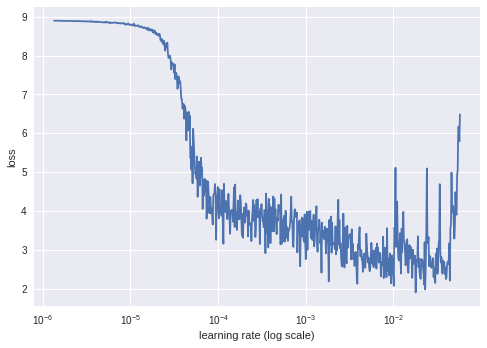

In [15]:
# model is a Keras model
lr_finder = LRFinder(model)

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(start_lr=0.000001, end_lr=1, batch_size=32, epochs=1, num_batches=num_train_images/32)

# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

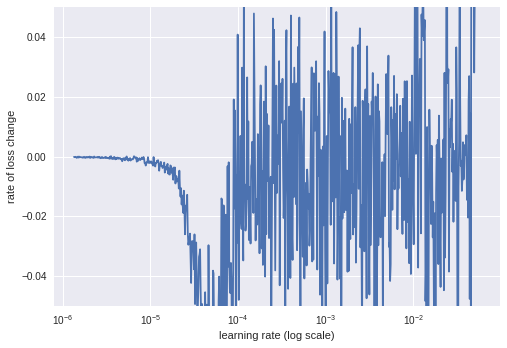

In [16]:
# Plot rate of change of the loss
# Ignore 20 batches in the beginning and 5 in the end
# Smooth the curve using simple moving average of 20 batches
# Limit the range for y axis to (-0.02, 0.01)
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.05, 0.05))

I ran fit_generator for 25 epochs, then for 5 epochs. What you see below is 5 epochs after 25 epochs.

If you don't want to train, download weights directly and load that and then go ahead for bleu score.
- 25th epoch: https://drive.google.com/open?id=1V0GGGVBmXL-9U63VsbXR8uavyGSyYu0o
- 30th epoch: https://drive.google.com/open?id=1g25CJT1CbTjrrIA9fASA1H18waAX665Y

In [24]:
filepath="image_caption_model9_non_random-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
model.fit_generator(generator=train_batch_generator(batch_size=32),
                    steps_per_epoch=num_train_images/32,
                    epochs=30, validation_data = valid_batch_generator(batch_size=32) , validation_steps=num_valid_images/32, callbacks=[checkpoint]
                    )

Epoch 1/30
928/937 [============================>.] - ETA: 0s - loss: 4.3553

IndexError: ignored

In [29]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

filename = 'weights-improvement-03-1.83.hdf5'
#model.save(filename)
uploaded = drive.CreateFile({'title': filename})
uploaded.SetContentFile(filename)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1-ySuTxXMIViM9IRyKtTJA3aQFk8M8TET


### 8. Calculate BLEU-1 score
 There are multiple metrics to evaluate a model. Here we use bleu score. 
 
 *token_to_word* is a dictionary which has number as key and its corresponding word. 
 
 Let's go through all the functions.
 
 *test_bleu_score*: This function calculates the bleu score on test data. For calculation of bleu score, we need references, to which our generated caption (hypothesis) (using generate_caption function) will be compared. 
 
 *generate_caption*: This function takes image name and returns the best caption for this image. First, it gets the best token (number representation of caption) (using get_best_token function) and then converts it to words using token_to_word dictionary and joins all the words.
 
 *get_best_token*: This function takes image encoding and beam size and returns the best token. The best is selected on the basis of log probability of the caption. At each iteration, we get top 3 partial captions (using get_top_next_partial function) and we stop iterating when we hit EOS ("zeosz") or max caption length for each caption.
 
 *get_top_next_partial*: This function takes current partial captions (top 3) and calculates top 3 for each partial caption. So at the end of for loop, we have 9 captions. Then we calculate top 3 and return the list. We don't calculate next word for a partial caption if it has EOS in the end or its length is max caption length.
 
 *log_softmax*: Since we didn't apply softmax in our model and depended on loss function to do that, here we do it on our own. After applying softmax, we apply log function.
 
 **This model gives a bleu score of 0.5848**

In [62]:
token_to_word = dict(zip(tokenizer.word_index.values(),
                                      tokenizer.word_index.keys()))
token_to_word[0] = ""

count = 0

def test_bleu_score():
  test_images, test_captions = get_data('Flickr8k_text/flickr_8k_test_dataset.txt')
  test_encoded_captions = tokenizer.texts_to_sequences(test_captions)
  test_captions = []
  for token in test_encoded_captions:
    token = token[:-1]
    caption = " ".join([token_to_word[x] for x in token])
    test_captions.append(caption)
  print(test_captions[:10])
    
  img_caption_pair = {}
  for i in range(len(test_images)):
    try:
      img_caption_pair[test_images[i]].append(test_captions[i])
    except:
      img_caption_pair[test_images[i]] = [test_captions[i]]
  
  hypothesis = []
  references = []
  
  for img_name,ref_captions in img_caption_pair.items():
    global count
    count = count +1 
    print(count)
    references.append(ref_captions)
    hypothesis.append(generate_caption(img_name))
    print(references[count-1])
    print(hypothesis[count-1])
  return bleu_score(references, hypothesis)

def generate_caption(image_name, max_tokens=39, beam_size=3):
    
    transfer_values = encoded_images[image_name]
    transfer_values = np.expand_dims(transfer_values, axis=0)
    
    token = get_best_token(transfer_values,beam_size)
    
    token = token[:-1]
    caption = " ".join([token_to_word[x] for x in token])
    #print("generated caption: " + caption)
    return caption
   
    
def get_best_token(transfer_values, beam_size):
  partial_tokens = get_top_first_token(transfer_values,beam_size)
  while True:
    valid_token_sum = sum([0 if (x[0][-1]==end_token or len(x[0])==39) else 1 for x in partial_tokens ])
    if(valid_token_sum==0):
      break
    partial_tokens = get_top_next_partial(partial_tokens,transfer_values,beam_size)
    
  partial_tokens.sort(key = lambda l:l[1])
  return partial_tokens[-1][0]
  
def get_top_next_partial(partial_tokens, transfer_values,beam_size):
  top_next_partial = []
  for token in partial_tokens:
    if(token[0][-1]!=end_token and len(token[0])<39):
      decoder_input_data = np.expand_dims(np.asarray(token[0]), axis=0)
      decoder_output = model.predict([transfer_values,decoder_input_data])
      next_word_no = len(token[0])
      next_token_list = decoder_output[0, next_word_no , :]
      next_token_prob_list = log_softmax(next_token_list)
      top_token_index = np.argsort(next_token_list)[-beam_size:]
      for i in range(beam_size):
        curr_token = token[0]
        curr_prob = token[-1]
        next_token_index = top_token_index[i]        
        new_prob = next_token_prob_list[next_token_index]
        top_next_partial.append([curr_token+[next_token_index],curr_prob+new_prob])
        
    else:
      top_next_partial.append(token)
  
  top_next_partial.sort(key = lambda l:l[1])
  return top_next_partial[-beam_size:]

def get_top_first_token(transfer_values, beam_size):
  top_next_partial = []
  decoder_output = model.predict([transfer_values,np.asarray([[0]])])
  next_word_no = 0
  next_token_list = decoder_output[0, next_word_no , :]
  next_token_prob_list = log_softmax(next_token_list)
  #print(next_token_prob_list)
  top_token_index = np.argsort(next_token_prob_list)[-beam_size:]
  #print(next_token_prob_list[4])
  for i in range(beam_size):
    next_token_index = top_token_index[i]        
    new_prob = next_token_prob_list[next_token_index]
    top_next_partial.append([[next_token_index],new_prob])
    
  return top_next_partial
    
def log_softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

def bleu_score(references, hypothesis):
	return nltk.translate.bleu_score.corpus_bleu(references, hypothesis)

print(test_bleu_score())


['the dogs are in the snow in front of a fence', 'the dogs play on the snow', 'two brown dogs playfully fight in the snow', 'two brown dogs wrestle in the snow', 'two dogs playing in the snow', 'a brown and white dog swimming towards some in the pool', 'a dog in a swimming pool swims toward sombody we cannot see', 'a dog swims in a pool near a person', 'small dog is paddling through the water in a pool', 'the small brown and white dog is in the pool']
1
['the dogs are in the snow in front of a fence', 'the dogs play on the snow', 'two brown dogs playfully fight in the snow', 'two brown dogs wrestle in the snow', 'two dogs playing in the snow']
a man in a blue shirt is walking on a beach
2
['a brown and white dog swimming towards some in the pool', 'a dog in a swimming pool swims toward sombody we cannot see', 'a dog swims in a pool near a person', 'small dog is paddling through the water in a pool', 'the small brown and white dog is in the pool']
a man in a blue shirt is jumping into a

### 9. Different things I tried
- I started with https://github.com/anuragmishracse/caption_generator. Since this model predicts one word and not the whole caption, datapoints were high (300k) and running with batch_size of 32 or 128 takes time. I took "prepare dataset" and "few lines of bleu_score" from this project.
- Then I tried to understand how we feed input to LSTM using http://adventuresinmachinelearning.com/keras-lstm-tutorial/
- Using https://daniel.lasiman.com/post/image-captioning/, I started building the model. This guy has done hyperparameter search using http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf. I tried with multiple embedding size (128,300,512), 300 was working good for me.
- I referred https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb for understanding loss function. 
- I used learning rate finder code from https://github.com/surmenok/keras_lr_finder. This is based on this paper https://arxiv.org/pdf/1506.01186.pdf and I first noticed this in fast.ai couse.

### 10. What else we can try?
- Use learning rate decay
- Use Bergstra hyper-parameter search to find out optimum embedding size, learning rate.
- Right now, generate_caption function takes only one image as input, can be implemented in batch. 
- We have not used model callback and metrics for the model. The preffered metric would be bleu score, but calculating that for every epoch would take time. This can be tried as well.

### 11. References and further readings
- https://github.com/anuragmishracse/caption_generator
- https://daniel.lasiman.com/post/image-captioning/
- https://github.com/tensorflow/models/tree/master/research/im2txt/im2txt
- https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/
- https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

**Papers**:
- Show and Tell: A Neural Image Caption Generator (https://arxiv.org/pdf/1411.4555.pdf)
- Cyclical Learning Rates for Training Neural Networks (https://arxiv.org/pdf/1506.01186.pdf)
- Random Search for Hyper-Parameter Optimization (http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)
- Densely Connected Convolutional Networks (https://arxiv.org/pdf/1608.06993.pdf)


In [18]:
idx = np.random.randint(6000,size=32)
print(idx)

[3258 3992 4723 1893 5462 5294 2944  846 5772 3266 1953 5753 2192 5886
 3391  951 5103 2547 3195 2619  834 5511  346 5575  705 5271 4607 2209
 4471    9 1480 2694]


In [26]:
print(train_images[25000:25050])

['2520255786_b70a3ec032.jpg', '2520255786_b70a3ec032.jpg', '2520255786_b70a3ec032.jpg', '2520255786_b70a3ec032.jpg', '2520255786_b70a3ec032.jpg', '3337046794_296bd2c7e0.jpg', '3337046794_296bd2c7e0.jpg', '3337046794_296bd2c7e0.jpg', '3337046794_296bd2c7e0.jpg', '3337046794_296bd2c7e0.jpg', '3229898555_16877f5180.jpg', '3229898555_16877f5180.jpg', '3229898555_16877f5180.jpg', '3229898555_16877f5180.jpg', '3229898555_16877f5180.jpg', '3339558806_b4afdc8394.jpg', '3339558806_b4afdc8394.jpg', '3339558806_b4afdc8394.jpg', '3339558806_b4afdc8394.jpg', '3339558806_b4afdc8394.jpg', '3053785363_50392f2c53.jpg', '3053785363_50392f2c53.jpg', '3053785363_50392f2c53.jpg', '3053785363_50392f2c53.jpg', '3053785363_50392f2c53.jpg', '3533470072_87a5b595ba.jpg', '3533470072_87a5b595ba.jpg', '3533470072_87a5b595ba.jpg', '3533470072_87a5b595ba.jpg', '3533470072_87a5b595ba.jpg', '315436114_6d386b8c36.jpg', '315436114_6d386b8c36.jpg', '315436114_6d386b8c36.jpg', '315436114_6d386b8c36.jpg', '315436114_6d386b